The main differencce in the volatility trading case this year from the previous few years is the fact there are now arrays of options of two different maturities making calendar spreads possible, also known as trading term structure.

This can be thought of as before we could only trade one dimension of the volatility surface, namely skew. Whereas now we can trade both dimensions of the surface.

### Objective 1
***Build a model to forecast the future volatility of the underlying ETF based on known information and given forecast ranges. Participants should use this model with an options pricing model to determine whether the market prices for options are overvalued or undervalued. They should then
trade the specific options accordingly.***

We know that the dynamic of an equity generally can be taken to be a Geometric Brownian Motion or an Itô Process;

$$dS_t = \mu S dt + \sigma S dW_t$$
 
$$\text{Where} ~ \mu = \text{drift rate} , \sigma =\text{vol}$$

$$dW_t  \text{is a Wiener Process meaning that} ~ dW_t \sim \mathcal{N}(0,1)$$

In this case

$$P_{RTM,t} = P_{t-1} (1 + r_t) ~ \text{r is a weiner process} ~ r_t \sim \mathcal{N}(0,\sigma^2) ~ \text{$\mu$ = 0 and $\sigma_t$ = 20}$$

Which implies that P has no drift rate as it is just the previous price + some random return drawn from the normal distribution with mean = 0 so it has no directional inclination

$$P_{RTM,t} = P_{t-1} + P_{t-1} r_t$$

This condition of no drift rate means that our strategy should never incorporate any directional inclination as clearly the price dynamic is completely random with no drift rate. We should hence try and keep our portfolio delta flat as any delta exposure will leave us exposed to the purely random fluctuations in the price of the underlying. This is also true of implied vol, meaning that the implied vol should always reflect the forecast realised vol as with no drift rate there is no way to successfully directionally forecast volatility.

$$\text{We also know that the future volatility of the ETF is going to be normally distributed as follows}$$

$$\sim \mathcal{N}(\mu,\sigma_t) ~where~ \mu = 0 ~and~ \sigma_t = 20$$

For this reason we can say that our forecast of future volatility is 20% at the outset.

***At the beginning of each week, the volatility value $(\sigma_t)$ will shift and the new
value will be provided to participants. In addition, at the middle of each week (e.g. 𝑡𝑡 = 38) an
analyst estimate of next week’s volatility value will be announced.***

So as we can see every week the $\sigma_t$ figure will change hence we will need to have a volatility parameter in our model in order to see whether the pricing is appropriate for the level of implicit volatility.

We are also told that; ***The volatility forecasts made by the market maker are uninformed and therefore will not always accurately reflect the future volatility of RTM*** which means we will need to develop a model to adjust our volatility forecast as we move through each week.

## Objective 1 Summary

Here we are only meant to find mispricings of the options relative to the underlying forecast realised volatility.

We are told that;

***The market maker will price the options using the BlackScholes model. It is important to note that the case assumes a risk-free rate of 0%. Mispricing will occur, creating trading opportunities for market
participants. These opportunities could be between specific options with respect to other options, specific options with respect to the underlying, or all options with respect to the underlying.***

In this particular section we are focused on the individual mispricings of options relative to the underlying.

- We will firstly use the Black Scholes Merton model to analytically price each individual option using the forecast level of volatility

- We compare the market price of individual options to those of the prices we have produced using the BSM model using our volatility forecast

- Next we will look at mispricing of options relative to eachother using the Put Call parity

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as si
import sympy as sy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings; warnings.simplefilter('ignore')

### Derivative on Underlying Equity - Itô's Lemma
We are told that the market maker will price the options using the Black Scholes Model but that there will be mispricings. In order to take advantage of these mispricings we will have to price the options using the Black Scholes model ourselves correctly in order to find any pricing discrepancies.

- We have just shown that an equity is taken to be an Itô Process, and given this information we can assume that an option follows Itö's Lemma as it's price is a function of the underlying. This means that it will follow;

$$\text{Taking the option price to be} ~ f(x)$$

$$\text{The dynamic of the option will follow} : df = (\frac{\partial f}{\partial t} + \mu S \frac{\partial f}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial f^2}{\partial S^2})dt + \sigma S \frac{\partial f}{\partial S} dW$$

### Black Scholes Merton Model
In order to derive the Black Scholes option pricing model from Itô's Lemma we must construct a theoretical portfolio;
- 1 Long Call (f)
- df/dS Short Underlying (S)

$$\text{This makes our portfolio equal to} P = f - \frac{\partial f}{\partial S} S$$

$$\text{Hence the dynamic of our portfolio is} \partial P = \partial f - \frac{\partial f}{\partial S} \partial S$$

$$\text{But we Already know that the dynmaic of dS is equal to} dS_t = \mu S dt + \sigma S dW_t \text{and the dynamic of df is equal to} ~ df = (\frac{\partial f}{\partial t} + \mu S \frac{\partial f}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial f^2}{\partial S^2})dt + \sigma S \frac{\partial f}{\partial S} dW$$

$$\text{Hence the dynamic of the portfolio is equal to} ~ dP = (\frac{\partial f}{\partial t} + \mu S \frac{\partial f}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial f^2}{\partial S^2} - \frac{\partial f}{\partial S} \mu S)dt + \sigma S ( \frac{\partial f}{\partial S} - \frac{\partial f}{\partial S} ) dW$$

$$dP = (\frac{\partial f}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial f^2}{\partial S^2} ) dt$$

Now since there is no dWt term there is no Weiner process component there is no risk and we can see that the delta of the portfolio is equal to 0. Since it is now risk - free we can now represent it's growth as;

$$dP = rPdt = r(f - \frac{\partial f}{\partial S} S) dt$$

Setting these two equations equal to eachother we get;

$$(\frac{\partial f}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial f^2}{\partial S^2} ) dt = r(f - \frac{\partial f}{\partial S} S) dt$$

$$\frac{\partial f}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial f^2}{\partial S^2}  = rf - rS \frac{\partial f}{\partial S}$$

$$\frac{\partial f}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial f^2}{\partial S^2} + rS \frac{\partial f}{\partial S}  = rf$$

$$\text{Now we have arrived at the Black Scholes PDE}$$

$$\text{We can see in the case that} ~ P_{RTM,t} = P_{t-1} (1 + r_t) ~ \text{where r is a weiner process} ~ r_t \sim \mathcal{N}(0,\sigma^2) ~ \text{where $\mu$ = 0 and $\sigma$ = 20}$$

Which implies that P has no drift rate as it is just the previous price + some random return drawn from the normal distribution with mean = 0

$$\text{so it has no directional inclination} ~ P_{RTM,t} = P_{t-1} + P_{t-1} r_t ~ \text{making it suitable to price options on using the Black Scholes Merton}$$

It is also worth noting here that this condition means that our strategy should never incorporate any directional inclination as clearly the price dynamic is completely random with no drift rate

From the BSM Model we can derive the following pricing formulae

$$C = S_t N(d_1) - K e ^{-e (T-t)} N(d_2)$$

$$P = K e ^{-e (T-t)} N(-d_2) - S_t N(-d_1)$$

where

$$d_1 = \frac{ln \frac{S_t}{K} + ( r + \frac{\sigma^2}{2} ) (T-t)}{\sigma \sqrt{T-t}}$$

$$d_2 = d_1 - \sigma \sqrt{T-t}$$

### Analytical Option Pricer

In [4]:
def vanilla(S, K, T, r, sigma, option = 'call'):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
    return result

Ofcourse we are very interested in the efficiency of our code so it may be optimal to use numerical methods such as Monte Carlo Methods to simulate our pricing

## Monte Carlo Methods Option Pricer

In [5]:
#n defines the time step, can't be > 365 if we only observe share price once per week
#nr = defines the number of simulations
#cp = + 1 for call / -1 for put
#dt = T/n time step length

def MonteCarloPricer(S,cp,K):
    nu = r - 0.5 * sigma **2
    S_val = np.zeros((nr, n+1)) #define results matrix
    rand = np.random.randn(nr,n)
    S_val[:,0] = S
    for i in range(nr): #start from 0 to nr so if nr times is 1000 then final entry will be 999
        for j in range(1,n+1): #range starting from 1 not 0 because need to use first j-1 column to begin iteration
            S_val[i,j] = S_val[i,j-1] * np.exp(nu*dt + sigma * dt**0.5 * rand[i, j-1])
            
    FinPayOff = np.maximum(cp*(S_val[:,-1] - K),0) #maximum per each simulation, compare each step with 0
    
    PDisc = np.exp( -r * T) * FinPayOff #payoff discounted to PV
    price = PDisc.mean() #average of all of the discounted simulations
    std = np.std(PDisc) #stdev of all of the discounted simulations
    
    #plot
    plt.figure
    for i in range(nr):
        plt.plot(S_val[i,:])
        plt.title('Monte Carlo Method simulations - GBM Paths')
    plt.show()
    return print("Price:",price,"Stdev:",std)
    
    #print('The price of the Monte Carlo Method with',nr,'simulation is %.5f.' % price)
    #print('The standard deviation is %.5f.' % std)

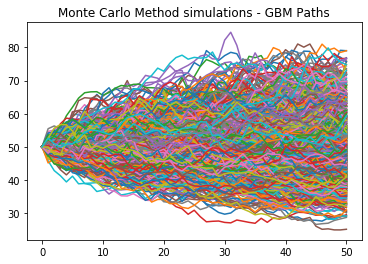

Price: 2.4082521076002665 Stdev: 4.754433833582892


In [6]:
sigma = 0.2
r = 0
T = 1
S = 50
K = 54
n = 50
nr = 1000
cp = 1
dt = T/n

#This should provide a price similar to our analytical value above

MonteCarloPricer(S,cp,K)

Defining a DataFrame as in the case documentation to work with

In [18]:
S = 50
K = {'Numerical_K':[45,46,47,48,49,50,51,52,53,54],
     'K/S':[45/S,46/S,47/S,48/S,49/S,50/S,51/S,52/S,53/S,54/S],
     'Call_P_1':[5.04,4.09,3.20,2.40,1.71,1.15,0.73,0.44,0.24,0.13],
     'Put_P_1':[0.04,0.09,0.20,0.40,0.71,1.15,1.73,2.44,3.24,4.13],
    'Call_P_2':[5.18,4.31,3.51,2.79,2.16,1.63,1.19,0.85,0.59,0.39],
    'Put_P_2':[0.18,0.31,0.51,0.79,1.16,1.63,2.19,2.85,3.59,4.39]}
df = pd.DataFrame(data=K)
df

,Numerical_K,K/S,Call_P_1,Put_P_1,Call_P_2,Put_P_2
0,45,0.90,5.04,0.04,5.18,0.18
1,46,0.92,4.09,0.09,4.31,0.31
2,47,0.94,3.20,0.20,3.51,0.51
3,48,0.96,2.40,0.40,2.79,0.79
4,49,0.98,1.71,0.71,2.16,1.16
5,50,1.00,1.15,1.15,1.63,1.63
6,51,1.02,0.73,1.73,1.19,2.19
7,52,1.04,0.44,2.44,0.85,2.85
8,53,1.06,0.24,3.24,0.59,3.59
9,54,1.08,0.13,4.13,0.39,4.39


### Individual Option Implied Vol mispricing relative to forecast realised

In [37]:
def individual(S, K, T, r, sigma, df):
    '''
    sigma - sigma forecast
    '''
    
    for i in range(len(df)-1):
        x_1 = vanilla(S,df["Numerical_K"][i],1/12,r,sigma,'call')
        x_2 = vanilla(S,df["Numerical_K"][i],2/12,r,sigma,'call')
        y_1 = vanilla(S,df["Numerical_K"][i],1/12,r,sigma,'put')
        y_2 = vanilla(S,df["Numerical_K"][i],2/12,r,sigma,'put')
        
        if x_1 < df["Call_P_1"][i]:
            print("At Strike",df["Numerical_K"][i],"Sell 1M call")
        elif x_1 > df["Call_P_1"][i]:
            print("At Strike",df["Numerical_K"][i],"Buy 1M call")
            
        if y_1 < df["Put_P_1"][i]:
            print("At Strike",df["Numerical_K"][i],"Sell 1M puts")
        elif y_1 > df["Put_P_1"][i]:
            print("At Strike",df["Numerical_K"][i],"Buy 1M puts")
            
        if x_2 < df["Call_P_2"][i]:
            print("At Strike",df["Numerical_K"][i],"Sell 2M call")
        elif x_2 > df["Call_P_2"][i]:
            print("At Strike",df["Numerical_K"][i],"Buy 2M call")
            
        if y_2 < df["Put_P_2"][i]:
            print("At Strike",df["Numerical_K"][i],"Sell 2M put")
        elif y_2 > df["Put_P_2"][i]:
            print("At Strike",df["Numerical_K"][i],"Buy 2M put")

In [38]:
individual(S, K, T, r, sigma, df)

At Strike 45 Sell 1M call
At Strike 45 Sell 1M puts
At Strike 45 Sell 2M call
At Strike 45 Sell 2M put
At Strike 46 Buy 1M call
At Strike 46 Buy 1M puts
At Strike 46 Buy 2M call
At Strike 46 Buy 2M put
At Strike 47 Buy 1M call
At Strike 47 Buy 1M puts
At Strike 47 Buy 2M call
At Strike 47 Buy 2M put
At Strike 48 Sell 1M call
At Strike 48 Sell 1M puts
At Strike 48 Buy 2M call
At Strike 48 Buy 2M put
At Strike 49 Sell 1M call
At Strike 49 Sell 1M puts
At Strike 49 Buy 2M call
At Strike 49 Buy 2M put
At Strike 50 Buy 1M call
At Strike 50 Buy 1M puts
At Strike 50 Sell 2M call
At Strike 50 Sell 2M put
At Strike 51 Buy 1M call
At Strike 51 Buy 1M puts
At Strike 51 Buy 2M call
At Strike 51 Buy 2M put
At Strike 52 Sell 1M call
At Strike 52 Sell 1M puts
At Strike 52 Sell 2M call
At Strike 52 Sell 2M put
At Strike 53 Buy 1M call
At Strike 53 Buy 1M puts
At Strike 53 Sell 2M call
At Strike 53 Sell 2M put


### Mispricing between specific options with respect to other option
There should be no delta bias in an option's price, we can take its price to be purely a function of its volatility.

Given we have been told that there will be mispricings of options relative to eachother we can assume there will be discrepancies in the implied volatility for given set strikes as these are the only options one can establish a mispricing because for a given strike the implied volatility should be consistent through puts and calls.

- I want to produce skew curves for both the puts and calls and from these
    - Whenever put skew curve is below call skew curve
        - Buy Put Options in this region as good value as vol is underpriced
        - Sell Call Options in this region as they are poor value as vol is overpriced

    - Whenever put skew curve is above call skew curve
        - Buy Call Options in this region as good value as vol is underpriced
        - Sell Call Options in this region as they are poor value as vol is overpriced
        
We could also incorporate this strategy on an individual level using the Put Call parity which is of the form

$$c + K e^{rT} = p + S_0$$

This is derived from the following identities

$$\text{The call option can never be worth more than the stock and never less than it's current intrinsic value}$$

$$S_0 - Ke^{-rT}  \leq c \leq S_0$$

$$\text{The put must be worth less than or equal to it's maximum possible payout $Ke^{-rT}$ and greater than it's current intrinsic value}$$

$$Ke^{-rT} - S_0 \geq p \geq ke^{-rT}$$

In [19]:
def specific_option_misprice(df):
    
    for i in range(len(df)-1):
        
        if df["Call_P_1"][i] > df["Put_P_1"][i] + S - df["Numerical_K"][i]*np.exp(-r*T):
            
            print("At Strike",df["Numerical_K"][i],"Buy Put 1M, Sell Call 1M")
            
        elif df["Call_P_1"][i] < df["Put_P_1"][i] + S - df["Numerical_K"][i]*np.exp(-r*T):
            
            print("At Strike",df["Numerical_K"][i],"Buy Call 1M, Sell Put 1M")
            
        if df["Call_P_2"][i] > df["Put_P_2"][i] + S - df["Numerical_K"][i]*np.exp(-r*T):
            
            print("At Strike",df["Numerical_K"][i],"Buy Put 2M, Sell Call 2M")
            
        elif df["Call_P_2"][i] < df["Put_P_2"][i] + S - df["Numerical_K"][i]*np.exp(-r*T):
            
            print("At Strike",df["Numerical_K"][i],"Buy Call 2M, Sell Put 2M")

In [20]:
sigma = 0.2
r = 0
T = 1
S = 50
K = 54
n = 50
nr = 1000
cp = 1
dt = T/n
specific_option_misprice(df)

At Strike 45 Buy Put 1M, Sell Call 1M
At Strike 46 Buy Call 1M, Sell Put 1M
At Strike 46 Buy Call 2M, Sell Put 2M
At Strike 47 Buy Call 1M, Sell Put 1M
At Strike 47 Buy Put 2M, Sell Call 2M
At Strike 48 Buy Put 1M, Sell Call 1M
At Strike 48 Buy Put 2M, Sell Call 2M
At Strike 49 Buy Call 1M, Sell Put 1M
At Strike 49 Buy Put 2M, Sell Call 2M
At Strike 50 Buy Put 1M, Sell Call 1M
At Strike 50 Buy Call 2M, Sell Put 2M
At Strike 51 Buy Put 1M, Sell Call 1M
At Strike 51 Buy Put 2M, Sell Call 2M
At Strike 52 Buy Put 1M, Sell Call 1M
At Strike 52 Buy Call 2M, Sell Put 2M
At Strike 53 Buy Call 1M, Sell Put 1M
At Strike 53 Buy Call 2M, Sell Put 2M


### Objective 2
***Use Greeks to calculate the portfolio exposure and hedge the position to reduce the risk of the portfolio while profiting from volatility differentials across options.***

## Delta Limits

We need to have a parameter which allows us to specify the maximum magnitude of delta which we are willing to take. An example in the documentation is given as 5000.

Hence, the ultimate goal is to stay delta neutral and only take vega positions. However in practice in a dynamic market this is impossible to achieve perfectly but we can get close to maintaining this.

We will be able to achieve this through a combination of the puts calls and equity positions.

However there are limits on each of these instruments too.

Gross/Net limit of shares is 50,000
Gross options limit is 2,500
Net options limit is 1,000

This means that we can only delta hedge with stocks up to a limit of 50,000 and each option position is representative of 100 contracts.

In [ ]:
def delta(S, K, T, r, sigma, option = 'call'):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = si.norm.cdf(d1, 0.0, 1.0)
    if option == 'put':
        result = -si.norm.cdf(-d1, 0.0, 1.0)
        
    return result

In [39]:
def theta(S, K, T, r, sigma, option = 'call'):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    prob_density = 1 / np.sqrt(2 * np.pi) * np.exp(-d1 ** 2 * 0.5)
    
    if option == 'call':
        theta = (-sigma * S * prob_density) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    if option == 'put':    
        theta = (-sigma * S * prob_density) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [ ]:
def gamma(S, K, T, r, sigma):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    prob_density = 1 / np.sqrt(2 * np.pi) * np.exp(-d1 ** 2 * 0.5)
    
    gamma = prob_density / (S * sigma * np.sqrt(T))
    
    return gamma

In [ ]:
def vega(S, S0, K, T, r, sigma):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    prob_density = 1 / np.sqrt(2 * np.pi) * np.exp(-d1 ** 2 * 0.5)
    
    vega = S0 * prob_density * np.sqrt(T)
    
    return vega

We want to keep track of the delta and vega of the entire portfolio

### Objective 3
***Seek arbitrage opportunities across different options and different expiries using calendar spreads.***

This instructs us to find arbitrage opportunities using calendar spreads however I also think there is an opportunity to find arbitrage opportunities through skew spreads.

First thing we need to do is develop an algorithm using numerical methods which will draw the implied volatility of the specific options out for us so that we may find arbitrage opportunities between both skew structure and term structure. The idea is that at any point in time or any strike the implied volatility should be the same.

In [21]:
def nr_imp_vol(S, K, T, f, r, sigma, option = 'call'):   
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #f: Option value
    #r: interest rate
    #sigma: volatility of underlying asset
    #option: where it is a call or a put option
    
    d1 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        fx = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0) - f
        vega = (1 / np.sqrt(2 * np.pi)) * S * np.sqrt(T) * np.exp(-(si.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
        
    if option == 'put':
        fx = K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0) - f
        vega = (1 / np.sqrt(2 * np.pi)) * S * np.sqrt(T) * np.exp(-(si.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    
    tolerance = 0.000001 #limit of margin accepted for newton raphson algorithm
    x0 = sigma #we take our known 
    xnew  = x0
    xold = x0 - 1
        
    while abs(xnew - xold) > tolerance:
    
        xold = xnew
        xnew = (xnew - fx - f) / vega
        
        return abs(xnew)

Now we are ready to implement a vol mispricing algorithm using the newton raphson infrastructure we have built

## Skew Trading

Given we have been told that there will be mispricings of options relative to eachother we can assume there will be discrepancies in the implied volatility for given set strikes as these are the only options one can establish a mispricing because for a given strike the implied volatility should be consistent through puts and calls in the absence of dividends under BSM;

$$D F_t [F_t (\phi ( d_+^{Call}) + \phi(-d_+^{Put})) - K(\phi(d_-^{Call}) + \phi(-d_-^{Put}))] = DF_t(F_t-K)$$
 
Since $\phi(x)+\phi(-x)=1$, put call parity holds if and only if $d_±^{Call}=d_±^{Put}$ so if and only if $\sigma_{Call}(t,K) = \sigma_{Put}(t,K)$

Hence:

- I want to produce skew curves for both the puts and calls and from these
    - Whenever put skew curve is below call skew curve
        - Buy Put Options in this region as good value as vol is underpriced
        - Sell Call Options in this region as they are poor value as vol is overpriced

    - Whenever put skew curve is above call skew curve
        - Buy Call Options in this region as good value as vol is underpriced
        - Sell Call Options in this region as they are poor value as vol is overpriced

In order to maintain within our strict delta limitations the strategy will systematically buy straddles at strikes where the implied vol is under priced and systematically sell vol at strikes where the vol is over priced

In [50]:
S = 50 #market price
sigma_release = 0.3 #NEWS FORECAST SIGMA
sigma = 0.2 #the volatility in the Wiener Process of the dynamic of the underlying

def imp_vol_mp(df,S, sigma_release):
    call_skew_1 = []
    for i in range(len(df)-1):
        x = nr_imp_vol(S, df["Numerical_K"][i], 1/12, df["Call_P_1"][i], r, sigma_release, option = 'call')
        call_skew_1.append(x)
        if x < sigma_release:
            #Buy as the implied vol is priced below what is forecast
            print("At Strike",df["Numerical_K"][i],"Buy 1M Call")
        elif x > sigma_release:
            #Sell as the implied vol is priced above what is forecast
            print("At Strike",df["Numerical_K"][i],"Sell 1M Call")
        else:
            print("At Strike",df["Numerical_K"][i],"The Call volatility is priced appropriately")
    
    put_skew_1 = []
    for i in range(len(df)-1):
        y = nr_imp_vol(S, df["Numerical_K"][i], 1/12, df["Put_P_1"][i], r, sigma_release, option = 'put')
        put_skew_1.append(y)
        if y < sigma_release:
            #Buy as the implied vol is priced below what is forecast
            print("At Strike",df["Numerical_K"][i],"Buy 1M Put")
        elif y > sigma_release:
            #Sell as the implied vol is priced above what is forecast
            print("At Strike",df["Numerical_K"][i],"Sell 1M Put")
        else:
            print("At Strike",df["Numerical_K"][i],"The Call volatility is priced appropriately")
            
            
    call_skew_2 = []
    for i in range(len(df)-1):
        x = nr_imp_vol(S, df["Numerical_K"][i], 2/12, df["Call_P_2"][i], r, sigma_release, option = 'call')
        call_skew_2.append(x)
        if x < sigma_release:
            #Buy as the implied vol is priced below what is forecast
            print("At Strike",df["Numerical_K"][i],"Buy 2M Call")
        elif x > sigma_release:
            #Sell as the implied vol is priced above what is forecast
            print("At Strike",df["Numerical_K"][i],"Sell 2M Call")
        else:
            print("At Strike",df["Numerical_K"][i],"The Call volatility is priced appropriately")
    
    put_skew_2 = []
    for i in range(len(df)-1):
        y = nr_imp_vol(S, df["Numerical_K"][i], 2/12, df["Put_P_2"][i], r, sigma_release, option = 'put')
        put_skew_2.append(y)
        if y < sigma_release:
            #Buy as the implied vol is priced below what is forecast
            print("At Strike",df["Numerical_K"][i],"Buy 2M Put")
        elif y > sigma_release:
            #Sell as the implied vol is priced above what is forecast
            print("At Strike",df["Numerical_K"][i],"Sell 2M Put")
        else:
            print("At Strike",df["Numerical_K"][i],"The Call volatility is priced appropriately")
    
    plt.plot(call_skew_1,marker='o',markersize=8,color='blue',linewidth=2)
    plt.plot(put_skew_1, marker='o',markersize=8,color='red',linewidth=2)
    plt.plot(call_skew_2,marker='o',markersize=8,color='green',linewidth=2)
    plt.plot(put_skew_2, marker='o',markersize=8,color='orange',linewidth=2)
    plt.legend([call_skew_1, put_skew_1,call_skew_2, put_skew_2], ['call_skew 1m', 'put_skew 1m, call_skew 2m', 'put_skew 2m'])
    red_patch = mpatches.Patch(color='red', label='put_skew 1M')
    blue_patch = mpatches.Patch(color='blue', label='call_skew 1M')
    green_patch = mpatches.Patch(color='green', label='call_skew 2M')
    orange_patch = mpatches.Patch(color='orange', label='put_skew 2M')
    plt.legend(handles=[blue_patch,red_patch,green_patch,orange_patch])
    plt.show()

At Strike 45 Sell 1M Call
At Strike 46 Sell 1M Call
At Strike 47 Sell 1M Call
At Strike 48 Buy 1M Call
At Strike 49 Buy 1M Call
At Strike 50 Buy 1M Call
At Strike 51 Buy 1M Call
At Strike 52 Buy 1M Call
At Strike 53 Buy 1M Call
At Strike 45 Buy 1M Put
At Strike 46 Buy 1M Put
At Strike 47 Buy 1M Put
At Strike 48 Buy 1M Put
At Strike 49 Buy 1M Put
At Strike 50 Buy 1M Put
At Strike 51 Buy 1M Put
At Strike 52 Buy 1M Put
At Strike 53 Sell 1M Put
At Strike 45 Sell 2M Call
At Strike 46 Sell 2M Call
At Strike 47 Buy 2M Call
At Strike 48 Buy 2M Call
At Strike 49 Buy 2M Call
At Strike 50 Buy 2M Call
At Strike 51 Buy 2M Call
At Strike 52 Buy 2M Call
At Strike 53 Buy 2M Call
At Strike 45 Buy 2M Put
At Strike 46 Buy 2M Put
At Strike 47 Buy 2M Put
At Strike 48 Buy 2M Put
At Strike 49 Buy 2M Put
At Strike 50 Buy 2M Put
At Strike 51 Buy 2M Put
At Strike 52 Buy 2M Put
At Strike 53 Buy 2M Put


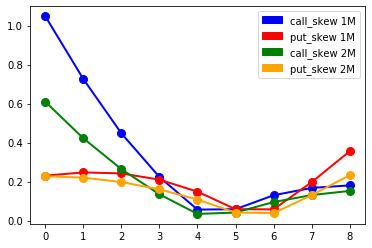

In [51]:
S = 50 #market price
sigma_release = 0.3 #NEWS FORECAST SIGMA
sigma = 0.2 #the volatility in the Wiener Process of the dynamic of the underlying

imp_vol_mp(df,S, sigma_release)

## Term Structure Trading Algorithm

### Logic below reference : Trading Volatility - Colin Bennett

Term structure is normally upward sloping when markets are flat or rising, however if equity markets decline usually leading to a spike in realised volatility, near dated implied vol tends to spike in a similar way and term structure may becomes inverted as short term implied vol rises. This is because volatility is expected to increase short term due to the equity decline.

In the case of an equity decline we can expect the term structure of options struck <100% to be more exaggeratedly inverted as a selloff is the market condition required for these options to be exercised.

On the other hand we expect options struck >100% to possess a comparitively more normal-upward sloping term structure as in order for these options to be exercied the market conditions required are increases in price which are not associated with increases in levels of implied volatility.

For this reason, unless there has been a spike in realised volatility (which may cause a similar spike in near dated implied volatility), we should imagine that all options struck <100% will have a flatter or more inverted term structure than all options struck >100% which will generally have a more normal - upwards sloping term structure.

- I want to produce term structure curves for particular strikes for both the puts and calls and from these
- Later I will add infrastructure to recognise and consider recent realised volatility activity and take this into consideration when analysing the shape of the term structures.
    - If strike of option is < 100% and there has been a spike in realised vol. TS may be slightly inverted
        - Buy 1m Options ans sell 2m Options in this region if implied volatility of 1m is considerably less than that of the 2m. 

    - If strike of options is > 100% and there has not ben a spike in realised vol. TS should usually be normal
        - Buy 2m Options ans sell 1m Options in this region if implied volatility of 1m is greater than that of the 2m

In [29]:
def termstructure(df):
    for i in range(len(df)-1):
        
        #1M and 2M Call Implied Vol
        x_1 = nr_imp_vol(S, df["Numerical_K"][i], 1/12, df["Call_P_1"][i], r, sigma_release, option = 'call')
        x_2 = nr_imp_vol(S, df["Numerical_K"][i], 1/6, df["Call_P_2"][i], r, sigma_release, option = 'call')
        
        #1M and 2M Put implied vol
        y_1 = nr_imp_vol(S, df["Numerical_K"][i], 1/12, df["Put_P_1"][i], r, sigma_release, option = 'put')
        y_2 = nr_imp_vol(S, df["Numerical_K"][i], 1/6, df["Put_P_2"][i], r, sigma_release, option = 'put')
        
        #if strike >= 100% term structure should be normal
        if df["K/S"][i] >= 1:
            
            #if inverted call term structure
            if x_2 < x_1:
                print("At Strike",df["Numerical_K"][i],"Buy 2M and Sell 1M Call")
            
            #if inverted put term structure
            if y_2 < y_1:
                print("At Strike",df["Numerical_K"][i],"Buy 2M and Sell 1M Put")
        
        #if strike < 100% term structure should be inverted
        if df["K/S"][i] < 1:
            
            #if normal call term structure
            if x_2 >= x_1:
                print("At Strike",df["Numerical_K"][i],"Buy 1M and Sell 2M Call")
            
            #if normal put term structure
            if y_2 >= y_1:
                print("At Strike",df["Numerical_K"][i],"Buy 1M and Sell 2M Put")

In [30]:
termstructure(df)

At Strike 50 Buy 2M and Sell 1M Call
At Strike 50 Buy 2M and Sell 1M Put
At Strike 51 Buy 2M and Sell 1M Call
At Strike 51 Buy 2M and Sell 1M Put
At Strike 52 Buy 2M and Sell 1M Call
At Strike 52 Buy 2M and Sell 1M Put
At Strike 53 Buy 2M and Sell 1M Call
At Strike 53 Buy 2M and Sell 1M Put


#### from the results here we see that the term structure is inverted for both calls and puts from strikes 50-53